In [14]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import xlsxwriter

from scipy.sparse import coo_matrix
from math import log, exp
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from PyNetSim import PyNetSim
from random import randint

np.set_printoptions(threshold=sys.maxint)
K = 100
"""make a checkpoint for time slice

:param step the step of each snapshot
:param row each row of the mataData and it looks like
        node1, node2, linkstart, linkend, connect time, totally connected time

"""


def time_slicer(steps, min_time, max_time):
    # how many snapshot we are going to have
    looper = (max_time - min_time)/steps
    checkpoints = [set([min_time + steps * l, min_time + steps * (l+1)]) for l in range(0, looper)]
    return checkpoints


"""
    Weight cacluation
"""


def link_weight(duration, ranges):
    return  exp(np.float64(duration)/ranges)


"Generate spare martix"
"""
One thing must remember is that node pair in the data has connected, so we don't need
worried about take node pair without connected into account.
"""


def weighted_spare_martix_generator(slice_start, slice_end, mataData,size, ranges):
    row = []
    col = []
    data = []
    m = np.zeros((size, size))
    for i in mataData:
        if i[2] == i[3]:
            duration = 1
        else:
            duration = i[3] - i[2]

        # sum weight up if we already have that data
            # sum weight up if we already have that data
            #if (i[0]-1) in row and col[row.index(int(i[0]-1))] == i[1]:
            #    data[row.index(int(i[0]-1))] += link_weight(duration, k)
            #else:
            #    row.append(i[0]-1)
            #    col.append(i[1]-1)
             #   data.append(link_weight(duration, k))
        row = int(i[0]-1)
        column = int(i[1]-1)

        if m[row, column] == 0:
            m[row, column] = link_weight(duration, ranges)
            m[column,row] = link_weight(duration,ranges)
        else:
            m[row, column] += link_weight(duration, ranges)
            m[column,row] += link_weight(duration,ranges)
    return m


def spare_martix_generator(slice_start, slice_end, mataData):
    row = []
    col = []
    data = []
    for i in mataData:
        if (i[2] >= slice_start and i[3] <= slice_end or
            i[2] <= slice_start and i[2] >= slice_start or
            i[3] <= slice_end and i[3] >= slice_end):
            # pdb.set_trace()
            if i[0] in row and col[row.index(i[0])] == i[1]:
                pass
            else:
                row.append(i[0]-1)
                col.append(i[1]-1)
                data.append(1)
    print row
    print col
    print data
    m = coo_matrix((data, (row, col)), shape=(SIZE, SIZE))
    return m


""""
    Caculate AUC
"""
def calculate_auc(csrMatrix ,simScore, sample_time = 100000):
    slots = []
    samples = []
    score = []
    for i in range(0, sample_time):
        tempr = randint(0,SIZE-1)
        tempc = randint(0,SIZE-1)
        if tempc != tempr:
            slots.append([tempr, tempc])
    samples = np.array([csrMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return roc_auc_score(samples, score)

""""
    plot roc
"""
def calculate_roc(csrMatrix ,simScore, sample_time = 100000):
    slots = []
    samples = []
    score = []
    for i in range(0, sample_time):
        tempr = randint(0,SIZE-1)
        tempc = randint(0,SIZE-1)
        if tempc != tempr:
            slots.append([tempr, tempc])
    samples = np.array([csrMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])
    return roc_curve(samples, score)

""""
    Caculate pre recall
"""
def calculate_pre_recall(csrMatrix ,simScore, sample_time = 100000):
    slots = []
    for i in range(0, sample_time):
        tempr = randint(0,SIZE-1)
        tempc = randint(0,SIZE-1)
        if tempc != tempr:
            slots.append([tempr, tempc])
    samples = np.array([csrMatrix[slot[0], slot[1]] for slot in slots])
    score = np.array([simScore[slot[0], slot[1]] for slot in slots])

    return precision_recall_curve(samples, score), average_precision_score(samples, score)


"""
    Caculate cosin simiary
"""
def calculate_cosin_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((SIZE,SIZE))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(0, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            nodes = G.nodes()
            if len(nodes) > 0:
                listi = [[wadj_martix[i, c] for c in nodes]]
                listj = [[wadj_martix[j, c] for c in nodes]]
                cosim = cosine_similarity(listi, listj)
                cosi_matrix[i,j] = cosim[0][0]
                cosi_matrix[j,i] = cosim[0][0]
    return cosi_matrix


"""
    Caculate weight CN
"""
def calculate_weight_cn_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((SIZE,SIZE))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(0, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            if len(cnlist) > 0:
                listi = [wadj_martix[i, c] for c in cnlist]
                listj = [wadj_martix[j, c] for c in cnlist]
                sim = sum(listi) + sum(listj)
                cosi_matrix[i,j] = sim
                cosi_matrix[j,i] = sim
    return cosi_matrix

"""
    Caculate weight RA
"""
def calculate_weight_ra_simiary(adj_martix, wadj_martix):
    cosi_matrix = np.zeros((SIZE,SIZE))
    G=nx.from_numpy_matrix(adj_martix)
    for i in range(0, adj_martix.shape[0]):
        for j in range(i+1, adj_martix.shape[0]):
            # get a list cn of (i,j)
            cnlist = sorted(nx.common_neighbors(G, i, j))
            
            if len(cnlist) > 0:
                listi = [wadj_martix[i, c] for c in cnlist]
                listj = [wadj_martix[j, c] for c in cnlist]
                strz = [sum(sorted(nx.neighbors(G,c))) for c in cnlist]
                sim = sum([listi[i]+listj[i]/strz[i] for i in range(0, len(listi))])
                cosi_matrix[i,j] = sim
                cosi_matrix[j,i] = sim
    return cosi_matrix

In [15]:
%%capture

mataData = np.genfromtxt("../MSNs data/Cambridge.txt")

# time range of the dataset
t_min = min(mataData[:, 2])
t_max = max(mataData[:, 3])
SIZE = max(mataData[:, 0]) if max(mataData[:, 1]) <  max(mataData[:, 1]) else  max(mataData[:, 1])
SIZE = int(SIZE)
time_range = t_max - t_min


spare_martix = spare_martix_generator(t_min, t_max, mataData)
weighted_spare_martix = weighted_spare_martix_generator(t_min, t_max, mataData,SIZE, time_range)

In [16]:
%%capture
# Load martix
csMatrix = spare_martix.tocsr()
csMatrix[csMatrix > 0] = 1
adj_martix = spare_martix.todense()
adj_martix[adj_martix > 0] = 1
wadj_martix = weighted_spare_martix


NetSim = PyNetSim.PyNetSim()
NetSim.ReadDataFromAdjacencyMatrix(adj_martix)
WNetSim = PyNetSim.PyNetSim()
WNetSim.ReadDataFromAdjacencyMatrix(wadj_martix)

In [17]:
G=nx.from_numpy_matrix(adj_martix)
print nx.info(G)
print nx.density(G)

edge_labels = dict()
for i in range(0, SIZE):
    for j in range(0, SIZE):
        key = tuple([i, j])
        edge_labels[key] = wadj_martix[i,j]

Name: 
Type: Graph
Number of nodes: 223
Number of edges: 480
Average degree:   4.3049
0.0193915888983


In [18]:
cosins = calculate_cosin_simiary(adj_martix, wadj_martix)

In [19]:
precision = dict()
recall = dict()
ave_pre = dict()
# katz_pre with unweigthed
katz_martix = NetSim.Katz(lamda=0.01)
temp, ave_pre["katz"]= calculate_pre_recall(adj_martix, katz_martix)
precision["katz"], recall["katz"], _ = temp


# lp_pre with unweigthed
LP_martix = NetSim.LocalPathIndex(lamda=0.01)
temp,  ave_pre["lp"] = calculate_pre_recall(adj_martix, LP_martix)
precision["lp"], recall["lp"],_ = temp


# CN_pre with unweighted
CN_martix = NetSim.CommonNeighbor()
temp,  ave_pre["cn"] = calculate_pre_recall(adj_martix, CN_martix)
precision["cn"], recall["cn"],_ = temp

# CN_pre with weighted
WCN_martix = calculate_weight_cn_simiary(adj_martix, wadj_martix)
temp,  ave_pre["wcn"] = calculate_pre_recall(adj_martix, WCN_martix)
precision["wcn"], recall["wcn"],_ = temp


# AA_pre with unweighted
AA_martix = NetSim.AdamicAdarIndex()
temp,  ave_pre["aa"] = calculate_pre_recall(adj_martix, AA_martix)
precision["aa"], recall["aa"],_ = temp

# RA_pre with unweighted
RA_martix = NetSim.ResourceAllocation()
temp,  ave_pre["ra"] = calculate_pre_recall(adj_martix, RA_martix)
precision["ra"], recall["ra"],_ = temp

# RA_pre with weighted
WRA_martix = calculate_weight_ra_simiary(adj_martix, wadj_martix )
temp,  ave_pre["wra"] = calculate_pre_recall(adj_martix, WRA_martix)
precision["wra"], recall["wra"],_ = temp

# wkatz_pre with weighted
Wkatz_martix = WNetSim.Katz(lamda=0.01)
temp,  ave_pre["wkatz"] = calculate_pre_recall(adj_martix, Wkatz_martix)
precision["wkatz"], recall["wkatz"],_ = temp


# wlp_pre with weighted
Wlp_martix = WNetSim.LocalPathIndex(lamda=0.01)
temp,  ave_pre["wlp"] = calculate_pre_recall(adj_martix, Wlp_martix)
precision["wlp"], recall["wlp"],_ = temp

# cosin sim
temp,  ave_pre["cosins"] = calculate_pre_recall(adj_martix, cosins)
precision["cosins"], recall["cosins"],_ = temp

# cosin sim
#temp,  ave_pre["cosinsidf"] = calculate_pre_recall(adj_martix, cosins_idf)
#precision["cosinsidf"], recall["cosinsidf"],_ = temp

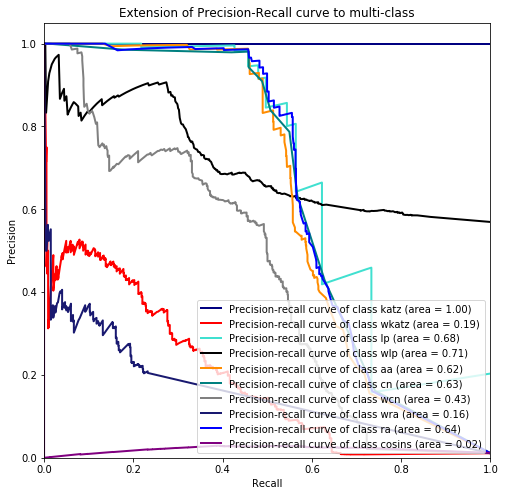

In [20]:
lw = 2
plt.figure(figsize=(8, 8))
# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["katz"], precision["katz"], color="navy", lw=lw,
            label='Precision-recall curve of class katz (area = {0:0.2f})'
                ''.format(ave_pre["katz"]))
plt.plot(recall["wkatz"], precision["wkatz"], color="r", lw=lw,
            label='Precision-recall curve of class wkatz (area = {0:0.2f})'
                ''.format(ave_pre["wkatz"]))


plt.plot(recall["lp"], precision["lp"], color="turquoise", lw=lw,
            label='Precision-recall curve of class lp (area = {0:0.2f})'
                ''.format(ave_pre["lp"]))
plt.plot(recall["wlp"], precision["wlp"], color="k", lw=lw,
            label='Precision-recall curve of class wlp (area = {0:0.2f})'
                ''.format(ave_pre["wlp"]))


plt.plot(recall["aa"], precision["aa"], color="darkorange", lw=lw,
            label='Precision-recall curve of class aa (area = {0:0.2f})'
                ''.format(ave_pre["aa"]))

plt.plot(recall["cn"], precision["cn"], color="teal", lw=lw,
            label='Precision-recall curve of class cn (area = {0:0.2f})'
                ''.format(ave_pre["cn"]))
plt.plot(recall["wcn"], precision["wcn"], color="grey", lw=lw,
            label='Precision-recall curve of class wcn (area = {0:0.2f})'
                ''.format(ave_pre["wcn"]))

plt.plot(recall["wra"], precision["wra"], color="midnightblue", lw=lw,
            label='Precision-recall curve of class wra (area = {0:0.2f})'
                ''.format(ave_pre["wra"]))
plt.plot(recall["ra"], precision["ra"], color="blue", lw=lw,
            label='Precision-recall curve of class ra (area = {0:0.2f})'
                ''.format(ave_pre["ra"]))

plt.plot(recall["cosins"], precision["cosins"], color="purple", lw=lw,
            label='Precision-recall curve of class cosins (area = {0:0.2f})'
                ''.format(ave_pre["cosins"]))

#plt.plot(recall["cosinsidf"], precision["cosinsidf"], color="midnightblue", lw=lw,
#            label='Precision-recall curve of class cosinsidf (area = {0:0.2f})'
#                ''.format(ave_pre["cosinsidf"]))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# katz_roc with unweigthed
fpr["katz"], tpr["katz"], _ = calculate_roc(csMatrix, katz_martix)
roc_auc["katz"] = auc(fpr["katz"], tpr["katz"])

# katz_roc with weighted
fpr["wkatz"], tpr["wkatz"], _ = calculate_roc(csMatrix, Wkatz_martix)
roc_auc["wkatz"] = auc(fpr["wkatz"], tpr["wkatz"])

# ip_roc with unweigthed
fpr["lp"], tpr["lp"], _ = calculate_roc(csMatrix, LP_martix)
roc_auc["lp"] = auc(fpr["lp"], tpr["lp"])

# CN_roc with unweighted
fpr["cn"], tpr["cn"], _ = calculate_roc(csMatrix, CN_martix)
roc_auc["cn"] = auc(fpr["cn"], tpr["cn"])

# WCN_roc with unweighted
fpr["wcn"], tpr["wcn"], _ = calculate_roc(csMatrix, WCN_martix)
roc_auc["wcn"] = auc(fpr["wcn"], tpr["wcn"])

# RA_roc with unweighted
fpr["ra"], tpr["ra"], _ = calculate_roc(csMatrix, AA_martix)
roc_auc["ra"] = auc(fpr["ra"], tpr["ra"])

# WRA_roc with unweighted
fpr["wra"], tpr["wra"], _ = calculate_roc(csMatrix, AA_martix)
roc_auc["wra"] = auc(fpr["wra"], tpr["wra"])

# AA_roc with unweighted
fpr["aa"], tpr["aa"], _ = calculate_roc(csMatrix, AA_martix)
roc_auc["aa"] = auc(fpr["aa"], tpr["aa"])



# lp_roc with weighted
fpr["wlp"], tpr["wlp"], _ = calculate_roc(csMatrix, Wlp_martix)
roc_auc["wlp"] = auc(fpr["wlp"], tpr["wlp"])

# cosins
fpr["cosins"], tpr["cosins"], _ = calculate_roc(csMatrix, cosins)
roc_auc["cosins"] = auc(fpr["cosins"], tpr["cosins"])

# cosins idf
#fpr["cosinsidf"], tpr["cosinsidf"], _ = calculate_roc(csMatrix, cosins_idf)
#roc_auc["cosinsidf"] = auc(fpr["cosinsidf"], tpr["cosinsidf"])

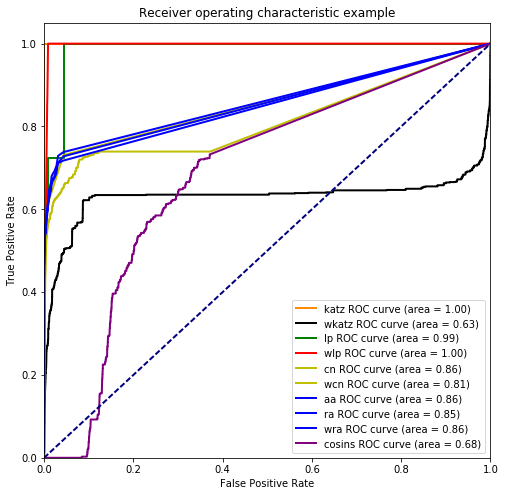

In [22]:
# plot roc
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr["katz"], tpr["katz"], color='darkorange',
         lw=lw, label='katz ROC curve (area = %0.2f)' % roc_auc["katz"])
plt.plot(fpr["wkatz"], tpr["wkatz"], color='k',
         lw=lw, label='wkatz ROC curve (area = %0.2f)' % roc_auc["wkatz"])

plt.plot(fpr["lp"], tpr["lp"], color='g',
         lw=lw, label='lp ROC curve (area = %0.2f)' % roc_auc["lp"])
plt.plot(fpr["wlp"], tpr["wlp"], color='r',
         lw=lw, label='wlp ROC curve (area = %0.2f)' % roc_auc["wlp"])


plt.plot(fpr["cn"], tpr["cn"], color='y',
         lw=lw, label='cn ROC curve (area = %0.2f)' % roc_auc["cn"])
plt.plot(fpr["wcn"], tpr["wcn"], color='y',
         lw=lw, label='wcn ROC curve (area = %0.2f)' % roc_auc["wcn"])

plt.plot(fpr["aa"], tpr["aa"], color='b',
         lw=lw, label='aa ROC curve (area = %0.2f)' % roc_auc["aa"])

plt.plot(fpr["ra"], tpr["ra"], color='b',
         lw=lw, label='ra ROC curve (area = %0.2f)' % roc_auc["ra"])
plt.plot(fpr["wra"], tpr["wra"], color='b',
         lw=lw, label='wra ROC curve (area = %0.2f)' % roc_auc["wra"])


plt.plot(fpr["cosins"], tpr["cosins"], color='purple',
         lw=lw, label='cosins ROC curve (area = %0.2f)' % roc_auc["cosins"])

#plt.plot(fpr["cosinsidf"], tpr["cosinsidf"], color='midnightblue',
#         lw=lw, label='cosinsidf ROC curve (area = %0.2f)' % roc_auc["cosinsidf"])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
